<a href="https://colab.research.google.com/github/hirotakasaito/dl_study/blob/main/pfrl_cartpole_drl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!apt update
!apt install xvfb
!pip install pyvirtualdisplay

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 222 kB in 2s (137 kB/s)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
15 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading packa

In [12]:
!pip3 install gym==0.22.0 pfrl==0.3.0

In [13]:
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from matplotlib import animation

evaluation episode: 300 R: 200.0


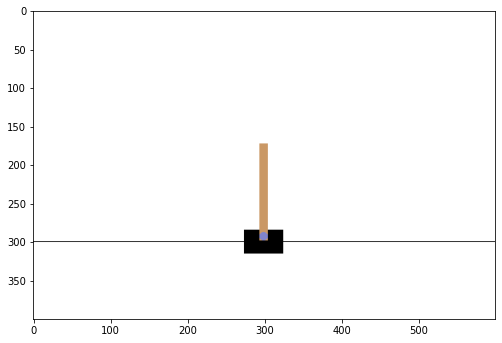

In [14]:
import pfrl
import torch
import torch.nn
import gym
import numpy


# 環境の生成
env = gym.make('CartPole-v0')


# Q関数の定義
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
q_func = torch.nn.Sequential(
   torch.nn.Linear(obs_size, 50),
   torch.nn.ReLU(),
   torch.nn.Linear(50, 50),
   torch.nn.ReLU(),
   torch.nn.Linear(50, n_actions),
   pfrl.q_functions.DiscreteActionValueHead(),
)


# エージェントの生成
agent = pfrl.agents.DoubleDQN(
   q_func, # Q関数
   optimizer=torch.optim.Adam(q_func.parameters(), eps=1e-2), # オプティマイザ
   replay_buffer=pfrl.replay_buffers.ReplayBuffer(capacity=10 ** 6), # リプレイバッファ
   gamma=0.9, # 将来の報酬割引率
   explorer=pfrl.explorers.ConstantEpsilonGreedy( # 探索(ε-greedy)
       epsilon=0.3, random_action_func=env.action_space.sample),
   replay_start_size=500, # リプレイ開始サイズ
   update_interval=1, # 更新インターバル
   target_update_interval=100, # ターゲット更新インターバル
   phi=lambda x: x.astype(numpy.float32, copy=False), # 特徴抽出関数
   gpu=-1, # GPUのデバイスID（-1:CPU）
)


# エージェントの学習
n_episodes = 300 # エピソード数
max_episode_len = 200 # 最大エピソード長

#calobで可視化するためのコード
d = Display()
d.start()
img = []
# エピソードの反復
for i in range(1, n_episodes + 1):
    # 環境のリセット
    obs = env.reset()
    R = 0  # エピソード報酬
    t = 0  # ステップ

    # ステップの反復
    while True:

        # 行動の推論
        action = agent.act(obs)

        # 環境の1ステップ実行
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)

        # エピソード完了
        if done or reset:
            break

    # ログ出力
    if i % 10 == 0:
        print('episode:', i, 'R:', R)
    if i % 50 == 0:
        print('statistics:', agent.get_statistics())
print('Finished.')


# エージェントのテスト
with agent.eval_mode():

    # 環境のリセット
    obs = env.reset()
    R = 0  # エピソード報酬
    t = 0  # ステップ

    # ステップの反復
    while True:
        # 環境の描画
        display.clear_output(wait=True)
        img.append(env.render('rgb_array'))

        # 環境の1ステップ実行
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        reset = t == 200
        agent.observe(obs, r, done, reset)

        # エピソード完了
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)

dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))